# Component-wise Dirichlet BC
Author: Jørgen S. Dokken

In this section, we will learn how to prescribe Dirichlet boundary conditions on a component of your unknown $u_h$.
We will illustrate the problem using a `VectorElement`. However, the method generalizes to any `MixedElement`.

We will use a slightly modified version of [the linear elasticity demo](./../chapter2/linearelasticity_code), namely
$$
-\nabla \cdot \sigma (u) = f\quad \text{in } \Omega,
$$

$$
\sigma \cdot n = 0 \quad \text{on } \partial \Omega_N,
$$

$$
u= 0\quad \text{at } \partial\Omega_{D},
$$

$$
u_x=0 \quad \text{at } \partial\Omega_{Dx},
$$

$$
\sigma(u)= \lambda \mathrm{tr}(\epsilon(u))I + 2 \mu \epsilon(u), \qquad \epsilon(u) = \frac{1}{2}\left(\nabla u + (\nabla u )^T\right).
$$
We will consider a two dimensional box spanning $[0,L]\times[0,H]$, where
$\partial\Omega_N$ is the left and right side of the beam, $\partial\Omega_D$ the bottom of the  beam, while $\partial\Omega_{Dx}$ is the right side of the beam.
We will prescribe a displacement $u_x=0$ on the right side of the beam, while the beam is being deformed under its own weight. The sides of the box is traction free.

In [1]:
L = 1
H = 1.3
lambda_ = 1.25 
mu = 1
rho = 1
g = 1

As in the previous demos, we define our mesh and function space. We will create a `ufl.VectorElement` to create a two dimensional vector space.

In [2]:
import dolfinx
import ufl
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
from dolfinx.cpp.mesh import CellType

mesh = dolfinx.RectangleMesh(MPI.COMM_WORLD, np.array([[0,0,0],[L, H,0]]), [30,30], cell_type=CellType.triangle)
element = ufl.VectorElement("CG", mesh.ufl_cell(), 1)
V = dolfinx.FunctionSpace(mesh, element)

## Boundary conditions
As we would like to clamp the boundary at $x=0$, we do this by using a marker function, we use `dolfinx.fem.locate_dofs_geometrical` to identify the relevant degrees of freedom.

In [3]:
def clamped_boundary(x):
    return np.isclose(x[1], 0)

u_D = dolfinx.Function(V)
with u_D.vector.localForm() as loc:
    loc.set(0)
bc = dolfinx.DirichletBC(u_D, dolfinx.fem.locate_dofs_geometrical(V, clamped_boundary))

Next we would like to constrain the $x$-component of our solution at $x=L$ to $0$. We start by creating the sub space only containing the $x$
-component.

In [4]:
V0 = V.sub(0).collapse()
uDx = dolfinx.Function(V0)
with uDx.vector.localForm() as uDx_loc:
    uDx_loc.set(0)

Next, we locate the degrees of freedom on the top boundary. However, as the boundary condition is in a sub space of our solution, we need to supply both the parent space $V$ and the sub space $V_0$ to `dolfinx.locate_dofs_geometrical`.

In [5]:
def right(x):
    return np.logical_and(np.isclose(x[0], L), x[1] < H)
boundary_dofs_x = dolfinx.fem.locate_dofs_geometrical((V.sub(0), V0), right)

We can now create our Dirichlet condition

In [6]:
bcx = dolfinx.DirichletBC(uDx, boundary_dofs_x, V.sub(0))
bcs = [bc, bcx]

As we want the traction $T$ over the remaining boundary to be $0$, we create a `dolfinx.Constant`

In [7]:
T = dolfinx.Constant(mesh, (0, 0))

We also want to specify the integration measure $\mathrm{d}s$, which should be the integral over the boundary of our domain. We do this by using `ufl`, and its built in integration measures

In [8]:
import ufl
ds = ufl.Measure("ds", domain=mesh)

## Variational formulation
We are now ready to create our variational formulation in close to mathematical syntax, as for the previous problems.

In [9]:
def epsilon(u):
    return ufl.sym(ufl.grad(u)) 
def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = dolfinx.Constant(mesh, (0, -rho*g))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

## Solve the linear variational problem
As in the previous demos, we assemble the matrix and right hand side vector and use PETSc to solve our variational problem

In [10]:
problem = dolfinx.fem.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

## Visualization


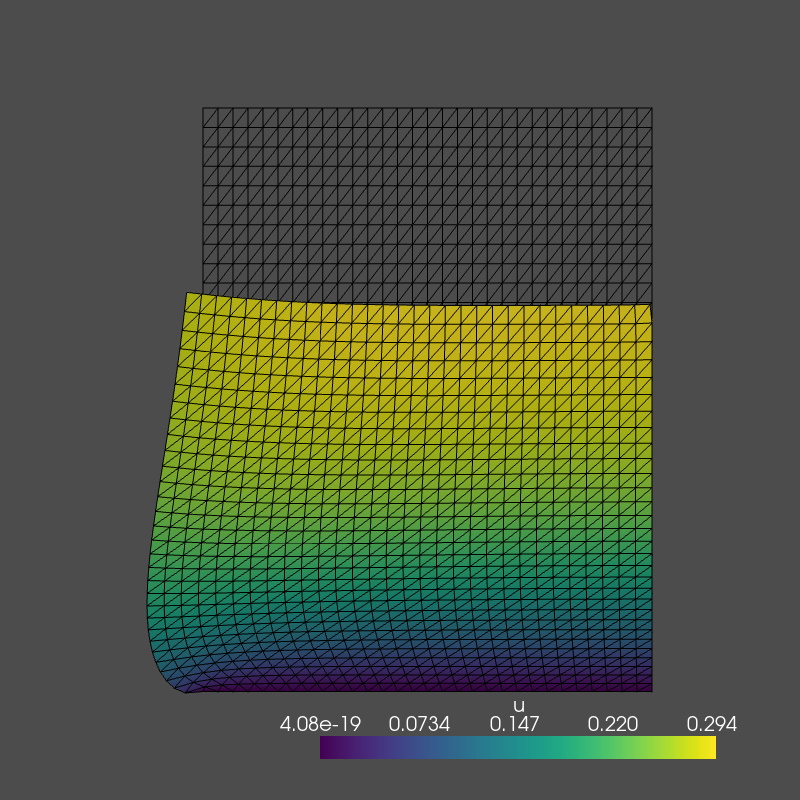

In [11]:
import pyvista
import dolfinx.plot
# Start virtual framebuffer
pyvista.start_xvfb(wait=0.05)

# Create plotter and pyvista grid
p = pyvista.Plotter(title="Deflection", window_size=[800, 800])
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

# Attach vector values to grid and warp grid by vector
vals_2D = uh.compute_point_values().real 
vals = np.zeros((vals_2D.shape[0], 3))
vals[:,:2] = vals_2D
grid["u"] = vals
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.view_xy()
if not pyvista.OFF_SCREEN:
   p.show()
fig_array = p.screenshot(f"component.png")